# LM-based Multiclass Classification of Cultural Items
**Homework 1 - Multilingual Natural Language Processing**

*By Joshua Edwin & Clemens Kubach*

**Methodology**
In this project, we considered what might be advantageous for a classification of cultural items.
We hypothesized that an LM pretrained on text from a variety of languages would have more cultural knowledge because language and culture are closely intertwined.
To test this hypothesis, we fine-tuned two pretrained LMs on our down-stream task: "BERT" and "Multilingual BERT".
Our experiments suggest that our hypothesis might be correct - "Multilingual BERT" actually performs better.
It should be mentioned that this is not representative, as this would go beyond the scope of the project.

We use our fine-tuned "Multilingual BERT" model as the homework requested transformer-based model.

## Prerequisites
Dependencies: Check that all required dependencies are installed as defined in `pyproject.toml`. Follow the `README.md` for more detailed instructions.

Authentication: The easiest approach for authentication is to add your WandB and Huggingface access tokens as secrets or environment variables.

## Machine and Environment Setup

In [1]:
from typing import Iterable

import pandas as pd
from datasets import DatasetDict, Dataset
import logging
import os


try:
    from google.colab import userdata  # type: ignore

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

logger = logging.getLogger(__name__)

from pathlib import Path
from git import Repo

def get_git_root(path: str = ".") -> str:
    repo = Repo(path, search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")

REPO_ROOT = Path(get_git_root())
DATA_DIR = REPO_ROOT / "data"
LOG_DIR = REPO_ROOT / "logs"
WANDB_DIR = REPO_ROOT / "wandb"

os.environ["WANDB_PROJECT"] = "mnlp-h1-lm"
os.environ["WANDB_DIR"] = str(WANDB_DIR)

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kubach to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Select the columns that should be used for training (all ignoring category or only name+description).

In [3]:
SELECT_ALL_COLS = False
SELECTED_COLUMNS = ("name", "type", "category", "subcategory", "description") if SELECT_ALL_COLS else ("name", "description")
print(f"Selected columns: {SELECTED_COLUMNS}")

Selected columns: ('name', 'description')


### Huggingface Login and Loading Data
To access the dataset, there are three options available that will be tried in the following fallback-order:


1.   From HF via HF_TOKEN secret/envvar if set.
2.   From HF via inserting the HF token manually in the login dialog.
3.   From local `./train.csv` and `./valid.csv` files.

Afterwards the hf dataset instance and train, val dataframes can be accessed via `hf_dataset`, `df_train` and `df_val`.

In [4]:
from os import environ

from datasets import load_dataset
from huggingface_hub import login
from datasets.exceptions import DatasetNotFoundError
from huggingface_hub.errors import HfHubHTTPError


def extract_dev_subsets_from_hf_dataset(
    ds: DatasetDict,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    _df_train = pd.DataFrame(ds["train"])  # Silver-labeled training set
    _df_validation = pd.DataFrame(ds["validation"])  # Gold-labeled dev set
    return _df_train, _df_validation


def read_hf_token() -> str | None:
    if IN_COLAB:
        try:
            return userdata.get("HF_TOKEN")
        except KeyError:
            return None
    else:
        return environ.get("HF_TOKEN", None)


def do_blocking_hf_login():
    # run the login in a separate cell because login is non-blocking
    try:
        token = read_hf_token()
        login(token=token)
        if token is None:
            # block until logged-in
            input("Press enter of finish login!")
    except (HfHubHTTPError, DatasetNotFoundError):
        print(
            "Login via HF_TOKEN secret/envvar and via manual login widget failed "
            "or not authorized."
        )


do_blocking_hf_login()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
def build_hf_dataset(train_df: pd.DataFrame, val_df: pd.DataFrame) -> DatasetDict:
    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(val_df)
    dataset_dict = DatasetDict(
        {"train": train_dataset, "validation": valid_dataset}
    )
    return dataset_dict

def aggregate_selected_columns(df: pd.DataFrame, selected_fields: Iterable[str]) -> pd.DataFrame:
    """Combine str cols in the following pattern: name: <name>; type: <type>; ... via iterating over selected_fields"""
    agg_df = df[list(selected_fields)].copy()
    agg_df['text'] = agg_df.apply(
        lambda row: '; '.join(f"{col}: {row[col]}" for col in selected_fields),
        axis=1
    )
    agg_df['label'] = df['label']
    return agg_df

def load_train_val_data() -> tuple[DatasetDict, pd.DataFrame, pd.DataFrame]:
    try:
        _ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
        _df_train, _df_val = extract_dev_subsets_from_hf_dataset(_ds)
        _df_train = aggregate_selected_columns(_df_train, selected_fields=SELECTED_COLUMNS)
        _df_val = aggregate_selected_columns(_df_val, selected_fields=SELECTED_COLUMNS)
        dataset_dict = build_hf_dataset(_df_train, _df_val)
        return dataset_dict, _df_train, _df_val
    except (HfHubHTTPError, DatasetNotFoundError) as e:
        logger.error(
            f"Something went wrong during HF dataset access: {e}. "
            "Falling back to local files:"
        )
    try:
        train_df = pd.read_csv("train.csv")
        valid_df = pd.read_csv("valid.csv")
        train_df = aggregate_selected_columns(train_df, selected_fields=SELECTED_COLUMNS)
        valid_df = aggregate_selected_columns(valid_df, selected_fields=SELECTED_COLUMNS)
        dataset_dict = build_hf_dataset(train_df, valid_df)
        return dataset_dict, train_df, valid_df
    except FileNotFoundError:
        raise FileNotFoundError(
            "Tried to access the dataset from Huggingface "
            "(via HF_TOKEN secret/envvar and manual auth) and from the local disk"
            "(via train.csv and valid.csv in the cwd) without success."
        )


hf_dataset, df_train, df_val = load_train_val_data()

# Show samples
print("\nTrain Set:")
display(df_train.head())

print("\nValidation Set:")
display(df_val.head())


Train Set:


,name,description,text,label
0,916,2012 film by M. Mohanan,name: 916; description: 2012 film by M. Mohanan,cultural exclusive
1,!!!,American dance-punk band from California,name: !!!; description: American dance-punk ba...,cultural representative
2,¡Soborno!,Mort & Phil comic,name: ¡Soborno!; description: Mort & Phil comic,cultural representative
3,+44,American band,name: +44; description: American band,cultural representative
4,1 Monk Street,"building in Monmouth, Wales",name: 1 Monk Street; description: building in ...,cultural exclusive



Validation Set:


,name,description,text,label
0,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",name: 1. FC Nürnberg; description: German spor...,cultural representative
1,77 Records,UK record label,name: 77 Records; description: UK record label,cultural exclusive
2,A Bug's Life,1998 animated film directed by John Lasseter a...,name: A Bug's Life; description: 1998 animated...,cultural representative
3,A Gang Story,2011 film by Olivier Marchal,name: A Gang Story; description: 2011 film by ...,cultural exclusive
4,Aaron Copland,"American composer, composition teacher, writer...",name: Aaron Copland; description: American com...,cultural representative


Show existing class labels:

In [6]:
df_train["label"].unique()

array(['cultural exclusive', 'cultural representative',
       'cultural agnostic'], dtype=object)

Plot the number of instances per class label. This will be executed on train and val set to determine whether the dataset is balanced and the data used for training is similarly distributed as the validation data.

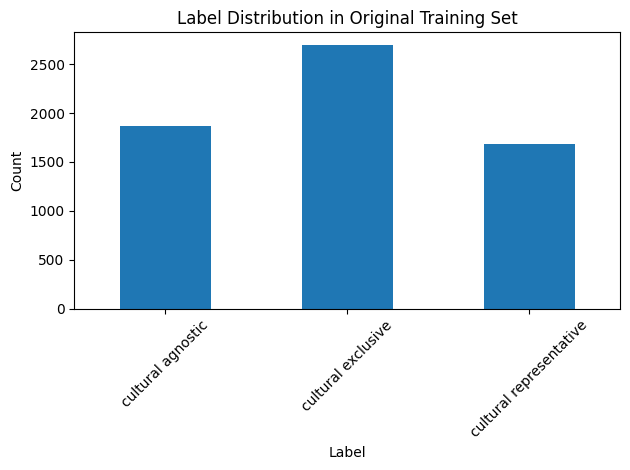

Class Ratios in Original Training Set:
label
cultural agnostic          0.30
cultural exclusive         0.43
cultural representative    0.27
Name: proportion, dtype: float64


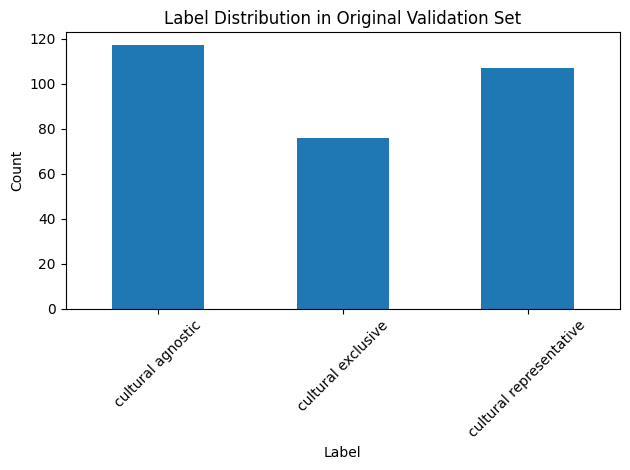

Class Ratios in Original Validation Set:
label
cultural agnostic          0.39
cultural exclusive         0.25
cultural representative    0.36
Name: proportion, dtype: float64


In [7]:
import matplotlib.pyplot as plt

def plot_label_distribution(df: pd.DataFrame, set_name: str):
    label_counts = df["label"].value_counts().sort_index()
    label_ratios = df["label"].value_counts(normalize=True).sort_index().round(2)

    label_counts.plot(kind="bar")
    plt.title(f"Label Distribution in {set_name}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Class Ratios in {set_name}:")
    print(label_ratios)

plot_label_distribution(df_train, set_name="Original Training Set")
plot_label_distribution(df_val, set_name="Original Validation Set")

Balance the training dataset by the class distribution.

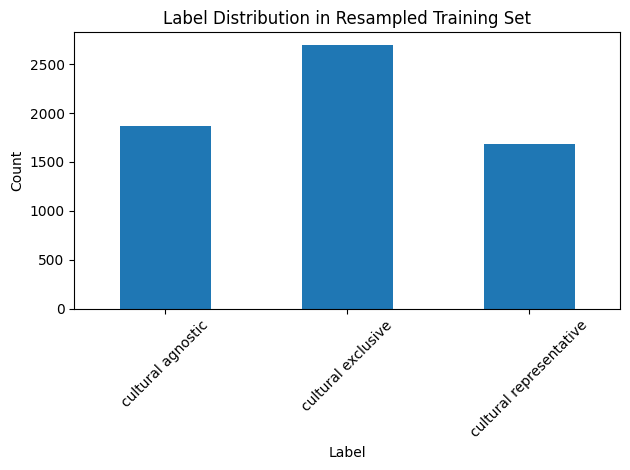

Class Ratios in Resampled Training Set:
label
cultural agnostic          0.30
cultural exclusive         0.43
cultural representative    0.27
Name: proportion, dtype: float64


In [8]:
from sklearn.utils import resample


def oversample(dataset: Dataset, label_col: str = "label") -> tuple[Dataset, pd.DataFrame]:
    df = dataset.to_pandas()
    grouped = [group for _, group in df.groupby(label_col)]
    max_count = max(len(g) for g in grouped)
    oversampled_groups = [
        resample(group, replace=True, n_samples=max_count, random_state=24)
        for group in grouped
    ]
    df_balanced = pd.concat(oversampled_groups).sample(frac=1, random_state=24).reset_index(drop=True)
    return Dataset.from_pandas(df_balanced, preserve_index=False), df_balanced


def match_train_to_val_distribution(
        train_dataset: Dataset,
        val_dataset: Dataset,
        label_col: str = "label",
) -> tuple[Dataset, pd.DataFrame]:
    train_df = train_dataset.to_pandas()
    val_df = val_dataset.to_pandas()
    val_label_dist = val_df[label_col].value_counts(normalize=True)
    total_train_samples = len(train_df)
    # Resample each class in train set to match val distribution
    matched_groups = []
    for label, frac in val_label_dist.items():
        group = train_df[train_df[label_col] == label]
        if len(group) == 0:
            continue
        n_samples = int(round(total_train_samples * frac))
        sampled_group = resample(group, replace=True, n_samples=n_samples, random_state=24)
        matched_groups.append(sampled_group)
    matched_df = pd.concat(matched_groups).sample(frac=1, random_state=24).reset_index(drop=True)
    return Dataset.from_pandas(matched_df, preserve_index=False), matched_df


# hf_dataset["train"], df_train = oversample(hf_dataset["train"])
# hf_dataset["train"], df_train = match_train_to_val_distribution(hf_dataset["train"], hf_dataset["validation"])
plot_label_distribution(df_train, set_name="Resampled Training Set")


In [9]:
print("HF dataset instance keys:", list(hf_dataset.keys()))
print("Train columns:", list(df_train.columns))
print("Val columns:", list(df_val.columns))

HF dataset instance keys: ['train', 'validation']
Train columns: ['name', 'description', 'text', 'label']
Val columns: ['name', 'description', 'text', 'label']


## LM-based Approach

We use different pretrained language models that are based on transformer architectures. For this, we will use the Huggingface Transformers library.

We will focus on the following models:
- BERT Base Cased
- BERT Base Multilingual Cased

Further experiments with other/larger models:
- XLM RoBERTa Large
- XLM RoBERTa Base

We adjusted the hyperparameters and training settings to mitigate overfitting and improve the performance of the model.

The models will be trained on the training set and evaluated on the validation set. The results will be logged to Weights & Biases (wandb) for further analysis.

### Pretrained Model Selection
Select the pretrained LM model that should be used for fine-tuning on our down-stream task

In [10]:
MODEL_NAME = "google-bert/bert-base-cased"
# MODEL_NAME = "bert-base-multilingual-cased"

# Further experiments with other/larger models:
# MODEL_NAME = "FacebookAI/xlm-roberta-base"
# MODEL_NAME = "facebook/xlm-roberta-xl" # too large for gpu
# MODEL_NAME = "FacebookAI/xlm-roberta-large" # works with Adafactor and gradient checkpointing
# MODEL_NAME = "google-bert/bert-large-cased"

Define our label mapping for internal numerical representation and set seed for reproducibility.

In [11]:
from transformers import set_seed

LABEL2ID = {
    "cultural agnostic": 0,
    "cultural representative": 1,
    "cultural exclusive": 2,
}
ID2LABEL = {k: v for v, k in LABEL2ID.items()}
set_seed(24)

### Pre-Processing
Define the preprocessing procedure. Here, the selected data columns are aggregated to one string column and tokenized afterward.

In [12]:
from transformers import PreTrainedTokenizer, AutoTokenizer, DataCollatorWithPadding


class PreProcessor:

    def __init__(
            self,
            tokenizer_name: str,
            agg_in_fields: tuple[str, ...] = ("name", "description"),
            use_text_column: bool = True,
    ):
        self.tokenizer_name = tokenizer_name
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.use_text_column = use_text_column
        self.agg_in_fields = agg_in_fields

    def __call__(self, samples):
        return self.preprocess_function(samples, self.tokenizer, self.agg_in_fields, self.use_text_column)

    @staticmethod
    def preprocess_function(
            samples,
            tokenizer: PreTrainedTokenizer,
            agg_in_fields: tuple[str, ...],
            use_text_column: bool = True,
    ):
        """Aggregate and tokenize input fields and convert labels to integer ids."""
        if use_text_column:
            input_samples = tokenizer(samples["text"], truncation=True, padding=True)
        else:
            to_tokenize = [samples[col] for col in agg_in_fields]
            input_samples = tokenizer(*to_tokenize, truncation=True, padding=True)
        input_samples["labels"] = [LABEL2ID[label] for label in samples["label"]]
        return input_samples

preprocessor = PreProcessor(MODEL_NAME, SELECTED_COLUMNS)
data_collator = DataCollatorWithPadding(tokenizer=preprocessor.tokenizer)
preprocessed_hf_dataset = hf_dataset.map(preprocessor, batched=True)
required_columns = preprocessor.tokenizer.model_input_names + ['labels']
preprocessed_hf_dataset.set_format(type='torch', columns=required_columns)

preprocessed_hf_dataset

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['name', 'description', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6251
    })
    validation: Dataset({
        features: ['name', 'description', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
})

### Define Evaluation and Logging Procedures
Typical classification metrics are logged after each epoch. Especially, the F1-Score is a good fit for slightly imbalanced datasets as the validation set of our problem.

In [13]:
import evaluate
import numpy as np


class Evaluator:

    def __init__(self):
        self.accuracy = evaluate.load("accuracy")
        self.f1 = evaluate.load("f1")
        self.precision = evaluate.load("precision")
        self.recall = evaluate.load("recall")

    def __call__(self, eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy_results = self.accuracy.compute(predictions=predictions, references=labels)
        f1_results = self.f1.compute(predictions=predictions, references=labels, average="weighted")
        precision_results = self.precision.compute(predictions=predictions, references=labels, average="weighted")
        recall_results = self.recall.compute(predictions=predictions, references=labels, average="weighted")
        # combine results to one dict
        results = {**accuracy_results, **f1_results, **precision_results, **recall_results}
        return results


evaluator = Evaluator()

We are using Weights and Biases for logging. Extending the default logging behavior, we are logging the predicted class distribution for the validation dataset.
This can be useful for inspecting whether the model learned to predict just one (e.g., the majority) class.

In [14]:
from transformers import TrainerCallback
from collections import Counter
from transformers.integrations import WandbCallback



def decode_predictions(model, predictions):
    id2label = model.config.id2label
    labels = [id2label[i] for i in predictions.label_ids]
    logits = predictions.predictions.argmax(axis=-1)
    prediction_text = [id2label[i] for i in logits]
    return {"labels": labels, "predictions": prediction_text}


class CustomWandbCallback(WandbCallback):

    def __init__(self, trainer, tokenizer, sample_dataset: Dataset):
        super().__init__()
        self.trainer = trainer
        self.tokenizer = tokenizer
        self.sample_dataset = sample_dataset

    def on_evaluate(self, args, state, control, **kwargs):
        super().on_evaluate(args, state, control, **kwargs)
        predictions = self.trainer.predict(self.sample_dataset)

        predicted_class_ids = predictions.predictions.argmax(axis=-1)
        del predictions
        id2label = self.trainer.model.config.id2label
        predicted_labels = [id2label[i] for i in predicted_class_ids]

        # self._wandb.log({"eval/predicted_class_distribution": wandb.Histogram(predicted_class_ids)}, step=state.global_step)
        label_counts = Counter(predicted_labels)
        label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count']).reset_index()
        label_df.columns = ['label', 'count']

        self._wandb.log({
            "eval/predicted_class_distribution": wandb.plot.bar(
                wandb.Table(dataframe=label_df),
                "label", "count",
                title="Predicted Class Distribution"
            )
        }, step=state.global_step)


class FreezeBERTCallback(TrainerCallback):
    def __init__(
            self,
            enable: bool,
            freeze_epochs: int,
            lr_before: float,
            lr_after: float,
            enable_lr_switch: bool = True,
    ):
        self.enable = enable
        self.freeze_epochs = freeze_epochs
        self.lr_before = lr_before
        self.lr_after = lr_after
        self.lr_switched = False
        self.enable_lr_switch = enable_lr_switch

    def on_epoch_begin(self, args, state, control, **kwargs):
        if not self.enable:
            return
        model = kwargs["model"]
        optimizer = kwargs["optimizer"]

        if state.epoch < self.freeze_epochs:
            if not self.lr_switched:
                for param in model.bert.parameters():
                    param.requires_grad = False
                if self.enable_lr_switch:
                    for group in optimizer.param_groups:
                        group['lr'] = self.lr_before
                if state.epoch == 1:
                    print(f"Epoch {int(state.epoch)}: BERT frozen")
        else:
            if not self.lr_switched:
                for param in model.bert.parameters():
                    param.requires_grad = True
                if self.enable_lr_switch:
                    for group in optimizer.param_groups:
                        group['lr'] = self.lr_after
                    self.lr_switched = True
                if state.epoch == self.freeze_epochs:
                    print(f"Epoch {int(state.epoch)}: BERT unfrozen")

### Initialize the Model
We are using Huggingface's AutoModelForSequenceClassification Interface to fine-tune a pre-trained LM with an additional classification head.

To counteract overfitting, an additional dropout is applied to the classifier head.

In [15]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, label2id=LABEL2ID, id2label=ID2LABEL, classifier_dropout=0.4
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Model Training
We are setting the Training and Trainer arguments and starting the training process.

We are **not using Early-stopping** mainly because of the epoch-wise double descent phenomenon, where the validation loss may initially increase after early improvement, but then improves significantly with continued training.

As an alternative, we are using **Model Checkpointing** after each epoch to be able to return the best model checkpoint accordingly to a specific evaluation metric.

For our experiments on larger models by default, we don't had enough GPU memory available on our used machines. Because of that, we tried some typical strategies to overcome the memory constraints like training on small batch-sizes, lower precision weights, and gradient checkpointing.

In [16]:
# from transformers.optimization import AdafactorSchedule
# from transformers import Adafactor

wandb.finish()
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
unique_run_name = f"{MODEL_NAME}-{SELECT_ALL_COLS}-{timestamp}"
HF_MODEL_NAME = f"cultural-{MODEL_NAME.split("/")[-1]}-classifier"

training_args = TrainingArguments(
    output_dir=LOG_DIR / MODEL_NAME,
    learning_rate=5e-6, # 2e-5, #5e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=10,
    num_train_epochs=20,
    weight_decay=0.01,
    # lr_scheduler_type="cosine_with_restarts",
    # warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="wandb",
    run_name=unique_run_name,
    push_to_hub=True,
    hub_model_id=f"ClemensK/{HF_MODEL_NAME}",
    hub_strategy="end"
    # gradient_accumulation_steps=16,
    # gradient_checkpointing=True,
    # fp16=True,
)

# optimizer = Adafactor(
#     model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None
# )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_hf_dataset["train"],
    eval_dataset=preprocessed_hf_dataset["validation"],
    processing_class=preprocessor.tokenizer,
    data_collator=data_collator,
    compute_metrics=evaluator,
    # callbacks=[
    #     FreezeBERTCallback(
    #         enable=False,
    #         freeze_epochs=5,
    #         lr_before=1e-3,
    #         lr_after=2e-5,
    #         enable_lr_switch=False,
    #     )
    # ],
    # optimizers=(optimizer, AdafactorSchedule(optimizer)),
)
trainer.add_callback(
    CustomWandbCallback(trainer, preprocessor.tokenizer, preprocessed_hf_dataset["validation"])
)

trainer.train()
if training_args.push_to_hub:
    trainer.push_to_hub()
wandb.finish()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.627200,0.652068,0.703333,0.694919,0.694944,0.703333
2,0.568700,0.633930,0.723333,0.714961,0.730175,0.723333
3,0.480900,0.604717,0.756667,0.752716,0.754121,0.756667
4,0.396700,0.608720,0.756667,0.751407,0.757086,0.756667
5,0.373200,0.636634,0.763333,0.758906,0.757095,0.763333
6,0.289200,0.711626,0.753333,0.747224,0.748132,0.753333
7,0.363300,0.730776,0.753333,0.745648,0.744032,0.753333
8,0.284700,0.762417,0.750000,0.742187,0.747272,0.750000
9,0.265200,0.820370,0.743333,0.737237,0.736719,0.743333
10,0.220000,0.861835,0.733333,0.725043,0.723076,0.733333


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

eval/accuracy,▁▁▃▃▇▇▇▇██▇▇▇▇▆▆▆▆▅▅▅▅▇▇▆▆▅▅▆▆▆▆▅▅▆▆▆▆▆▆
eval/f1,▁▁▃▃▇▇▇▇██▇▇▇▇▆▆▆▆▄▄▅▅▇▇▆▆▅▅▆▆▆▆▅▅▆▆▆▆▆▆
eval/loss,▂▂▁▁▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇████████
eval/precision,▁▁▅▅██████▇▇▇▇▇▇▆▆▄▄▅▅▇▇▆▆▅▅▆▆▆▆▅▅▆▆▆▆▆▆
eval/recall,▁▁▃▃▇▇▇▇██▇▇▇▇▆▆▆▆▅▅▅▅▇▇▆▆▅▅▆▆▆▆▅▅▆▆▆▆▆▆
eval/runtime,██▁▁▃▃▅▅▃▃▃▃▄▄▁▁▁▁▂▂▃▃▄▄▃▃▄▄▄▄▃▃▃▃▂▂▃▃▂▂
eval/samples_per_second,▁▁██▆▆▄▄▆▆▆▆▅▅████▆▆▆▆▅▅▅▅▅▅▅▅▆▆▆▆▇▇▆▆▆▆
eval/steps_per_second,▁▁██▆▆▄▄▆▆▆▆▅▅████▆▆▆▆▅▅▅▅▅▅▅▅▆▆▆▆▇▇▆▆▆▆
test/accuracy,▁▁▃▃▇▇▇▇██▇▇▇▇▆▆▆▆▅▅▅▅▇▇▆▆▅▅▆▆▆▆▅▅▆▆▆▆▆▆
test/f1,▁▁▃▃▇▇▇▇██▇▇▇▇▆▆▆▆▄▄▅▅▇▇▆▆▅▅▆▆▆▆▅▅▆▆▆▆▆▆
test/loss,▂▂▁▁▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇████████
